# SPTcl-IRAGN Number-Signal Radial Plot
### Author: Benjamin Floyd

Generates a publication plot showing how the number counts change as a function of signal both inside the cluster and outside. This should show a discrepancy of number counts due to the presence of the cluster over the field AGN.

In [1]:
import numpy as np
import json
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 14})

In [2]:
# Read in the AGN catalogs
sdwfs_agn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN.fits')
sptcl_agn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SPTcl_IRAGN.fits')

In [3]:
# Read in the AGN color-redshift threshold data
with open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color.json', 'r') as f:
    sdwfs_purity_data = json.load(f)

# Create interpolator
agn_purity_color = interp1d(sdwfs_purity_data['redshift_bins'][:-1], sdwfs_purity_data['purity_90_colors'], kind='previous')

In [4]:
# Select the AGN using a hard selection membership cut
sptcl_agn = sptcl_agn[sptcl_agn['SELECTION_MEMBERSHIP'] >= 0.5]

In [5]:
# Find the largest common radius in r500 units for all clusters
max_angular_radius = 2.5 * u.arcmin

cluster_z = [cat['REDSHIFT'][0] for cat in sptcl_agn.group_by('SPT_ID').groups]
cluster_r500 = [cat['R500'][0] for cat in sptcl_agn.group_by('SPT_ID').groups] * u.Mpc

max_physical_radius = u.Quantity([max_angular_radius * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc / u.arcmin) for z in cluster_z])
max_r500_radius = max_physical_radius / cluster_r500
common_radius = max_r500_radius.min()

In [6]:
# Separate the cluster into inner and outer samples
inner_cluster = sptcl_agn[sptcl_agn['RADIAL_SEP_R500'] <= common_radius]
outer_cluster = sptcl_agn[sptcl_agn['RADIAL_SEP_R500'] > common_radius]

In [7]:
# Bin the cluster data by the 4.5 um magnitudes
magnitude_bins = np.linspace(sptcl_agn['I2_MAG_APER4'].min(), sptcl_agn['I2_MAG_APER4'].max(), num=200)
inner_mag_binning = np.digitize(inner_cluster['I2_MAG_APER4'], magnitude_bins)
outer_mag_binning = np.digitize(outer_cluster['I2_MAG_APER4'], magnitude_bins)

inner_cluster_mag_binned = inner_cluster.group_by(inner_mag_binning)
outer_cluster_mag_binned = outer_cluster.group_by(outer_mag_binning)

In [8]:
# Count the number of objects brighter than the magnitude
inner_n, outer_n = [], []
for upper_mag in magnitude_bins[1:]:
    inner_n.append(inner_cluster[inner_cluster['I2_MAG_APER4'] < upper_mag]['COMPLETENESS_CORRECTION'].sum())
    outer_n.append(outer_cluster[outer_cluster['I2_MAG_APER4'] < upper_mag]['COMPLETENESS_CORRECTION'].sum())

/tmp/ipykernel_3781/105393957.py:2: RuntimeWarning: divide by zero encountered in log10
  ax.step(magnitude_bins[1:], np.log10(inner_n), label=fr'$\leq {common_radius:.2f} r_{{500}}$', where='post')


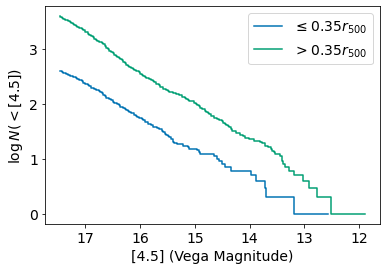

In [9]:
fig, ax = plt.subplots()
ax.step(magnitude_bins[1:], np.log10(inner_n), label=fr'$\leq {common_radius:.2f} r_{{500}}$', where='post')
ax.step(magnitude_bins[1:], np.log10(outer_n), label=fr'$> {common_radius:.2f} r_{{500}}$', where='post')
ax.legend()
ax.invert_xaxis()
ax.set(xlabel='[4.5] (Vega Magnitude)', ylabel=r'$\log N(<[4.5])$')
plt.show()